In [1]:
using_colab = False

In [2]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    # !{sys.executable} -m pip install opencv-python matplotlib
    # !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

    # !mkdir -p videos
    # !wget -P videos https://dl.fbaipublicfiles.com/segment_anything_2/assets/bedroom.zip
    # !unzip -d videos videos/bedroom.zip

    # !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

In [3]:
# !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

## Set-up

In [4]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [5]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


### Loading the SAM 2 video predictor

In [6]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "/home/campus.ncl.ac.uk/c1041562/Desktop/codes/sam2/checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [7]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

#### Select an example video

We assume that the video is stored as a list of JPEG frames with filenames like `<frame_index>.jpg`.

For your custom videos, you can extract their JPEG frames using ffmpeg (https://ffmpeg.org/) as follows:
```
ffmpeg -i <your_video>.mp4 -q:v 2 -start_number 0 <output_dir>/'%05d.jpg'
```
where `-q:v` generates high-quality JPEG frames and `-start_number 0` asks ffmpeg to start the JPEG file from `00000.jpg`.

In [8]:
import cv2

def save_top_10_seconds(input_video_path, output_video_path):
    """
    保存视频的前10秒帧到新视频文件，保持原视频质量
    """
    cap = cv2.VideoCapture(input_video_path)
    if not cap.isOpened():
        print(f"无法打开视频文件: {input_video_path}")
        return
    
    fps = cap.get(cv2.CAP_PROP_FPS)
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    # fourcc = int(cap.get(cv2.CAP_PROP_FOURCC))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 使用 mp4v 编码器
    
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))
    
    max_frames = int(fps * 10)  # 10秒对应的帧数
    frame_count = 0
    
    while frame_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break
        out.write(frame)
        frame_count += 1
    
    cap.release()
    out.release()
    print(f"已保存前10秒视频到: {output_video_path}")

# 使用示例
# process the first 10 seconds of a video file
input_path = "/home/campus.ncl.ac.uk/c1041562/Desktop/codes/sam2/dataset_3d_2cam/5-2a/1.mp4"
output_path = "/home/campus.ncl.ac.uk/c1041562/Desktop/codes/sam2/dataset_3d_2cam/5-2a/1_10.mp4"
save_top_10_seconds(input_path, output_path)
# process the second 10 seconds of a video file
input_path = "/home/campus.ncl.ac.uk/c1041562/Desktop/codes/sam2/dataset_3d_2cam/5-2a/2.mp4"
output_path = "/home/campus.ncl.ac.uk/c1041562/Desktop/codes/sam2/dataset_3d_2cam/5-2a/2_10.mp4"
save_top_10_seconds(input_path, output_path)

已保存前10秒视频到: /home/campus.ncl.ac.uk/c1041562/Desktop/codes/sam2/dataset_3d_2cam/5-2a/1_10.mp4
已保存前10秒视频到: /home/campus.ncl.ac.uk/c1041562/Desktop/codes/sam2/dataset_3d_2cam/5-2a/2_10.mp4


In [9]:
import cv2
import os


# proceed the first 10 seconds of a video file
video_path = "/home/campus.ncl.ac.uk/c1041562/Desktop/codes/sam2/dataset_3d_2cam/5-2a/1_10.mp4"
output_dir = "./3d_reconstruction/vid_dataset_frame_1-1-1_10"
# proceed the second 10 seconds of a video file
video_path_2 = "/home/campus.ncl.ac.uk/c1041562/Desktop/codes/sam2/dataset_3d_2cam/5-2a/2_10.mp4"
output_dir_2 = "./3d_reconstruction/vid_dataset_frame_1-1-2_10"

def video_preprocessing(video_path, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    cap = cv2.VideoCapture(video_path)
    frame_idx = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_path = os.path.join(output_dir, f"frame_{frame_idx:05d}.jpeg")
        cv2.imwrite(frame_path, frame)
        frame_idx += 1

    cap.release()
    print(f"视频已转换为 {frame_idx} 帧，保存在 {output_dir} 文件夹中。")

video_preprocessing(video_path, output_dir)
video_preprocessing(video_path_2, output_dir_2)

视频已转换为 300 帧，保存在 ./3d_reconstruction/vid_dataset_frame_1-1-1_10 文件夹中。
视频已转换为 300 帧，保存在 ./3d_reconstruction/vid_dataset_frame_1-1-2_10 文件夹中。


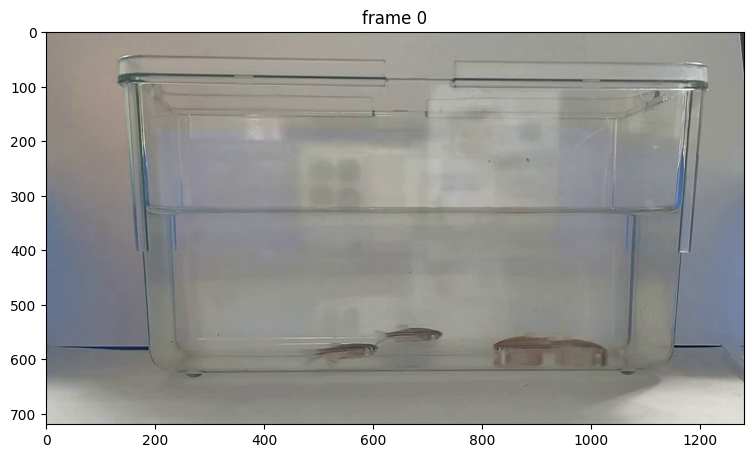

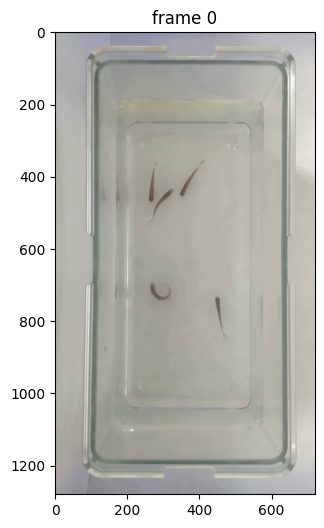

In [10]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`

import re

def extract_number(filename):
    match = re.search(r'\d+', os.path.splitext(filename)[0])
    return int(match.group()) if match else -1


def show_first_frame(video_dir):
    # scan all the JPEG frame names in this directory
    frame_names = [
        p for p in os.listdir(video_dir)
        if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
    ]
    # frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))
    frame_names.sort(key=extract_number)

    # take a look at the first video frame
    frame_idx = 0
    plt.figure(figsize=(9, 6))
    plt.title(f"frame {frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))
video_dir = "/home/campus.ncl.ac.uk/c1041562/Desktop/codes/sam2/notebooks/3d_reconstruction/vid_dataset_frame_1-1-1_10"
show_first_frame(video_dir)
video_dir_2 = "/home/campus.ncl.ac.uk/c1041562/Desktop/codes/sam2/notebooks/3d_reconstruction/vid_dataset_frame_1-1-2_10"
show_first_frame(video_dir_2)

#### Initialize the inference state

SAM 2 requires stateful inference for interactive video segmentation, so we need to initialize an **inference state** on this video.

During initialization, it loads all the JPEG frames in `video_path` and stores their pixels in `inference_state` (as shown in the progress bar below).

In [11]:
import os
from PIL import Image

src_dir = "/home/campus.ncl.ac.uk/c1041562/Desktop/codes/sam2/notebooks/3d_reconstruction/vid_dataset_frame_1-1-1_10"
dst_dir = "/home/campus.ncl.ac.uk/c1041562/Desktop/codes/sam2/notebooks/3d_reconstruction/vid_dataset_jpg_1-1-1_10"

os.makedirs(dst_dir, exist_ok=True)

frame_names = sorted(os.listdir(src_dir))
for i, fname in enumerate(frame_names):
    if fname.endswith(".jpeg"):
        img = Image.open(os.path.join(src_dir, fname))
        new_name = f"{i:05d}.jpeg"
        img.save(os.path.join(dst_dir, new_name))

In [12]:
video_dir = "/home/campus.ncl.ac.uk/c1041562/Desktop/codes/sam2/notebooks/3d_reconstruction/vid_dataset_jpg_1-1-1_10"
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|██████████| 300/300 [00:04<00:00, 62.89it/s]


### Example 1: Segment & track one object

Note: if you have run any previous tracking using this `inference_state`, please reset it first via `reset_state`.

(The cell below is just for illustration; it's not needed to call `reset_state` here as this `inference_state` is just freshly initialized above.)

In [13]:
predictor.reset_state(inference_state)

#### Step 1: Add a first click on a frame

To get started, let's try to segment the child on the left.

Here we make a **positive click** at (x, y) = (210, 350) with label `1`, by sending their coordinates and labels into the `add_new_points_or_box` API.

Note: label `1` indicates a *positive click (to add a region)* while label `0` indicates a *negative click (to remove a region)*.

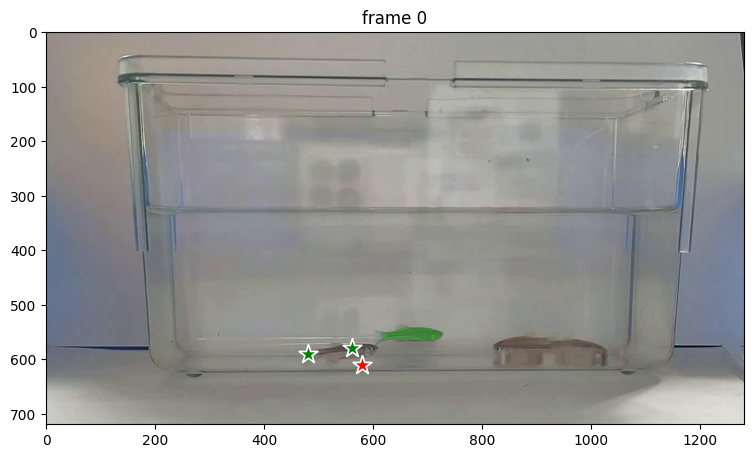

In [27]:
ann_frame_idx = 0 # the frame index we interact with
ann_obj_id = 0  # give a unique id to each object we interact with (it can be any integers)

frame_names_new = sorted(os.listdir(dst_dir))

points = np.array([[560, 580], [480, 590],[580, 610]], dtype=np.float32)
labels = np.array([1, 1, 0], np.int32)
def segment_and_show(frame_names, ann_frame_idx, ann_obj_id, points, labels):
    
    _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
        inference_state=inference_state,
        frame_idx=ann_frame_idx,
        obj_id=ann_obj_id,
        points=points,
        labels=labels,
    )

    plt.figure(figsize=(9, 6))
    plt.title(f"frame {ann_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
    show_points(points, labels, plt.gca())
    show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

segment_and_show(frame_names_new, ann_frame_idx, ann_obj_id, points, labels)

#### Step 2: Add a second click to refine the prediction

Hmm, it seems that although we wanted to segment the child on the left, the model predicts the mask for only the shorts -- this can happen since there is ambiguity from a single click about what the target object should be. We can refine the mask on this frame via another positive click on the child's shirt.

Here we make a **second positive click** at (x, y) = (250, 220) with label `1` to expand the mask.

Note: we need to send **all the clicks and their labels** (i.e. not just the last click) when calling `add_new_points_or_box`.

With this 2nd refinement click, now we get a segmentation mask of the entire child on frame 0.

#### Step 3: Propagate the prompts to get the masklet across the video

To get the masklet throughout the entire video, we propagate the prompts using the `propagate_in_video` API.

In [15]:
# def frame_processing_bypoint():
#     # run propagation throughout the video and collect the results in a dict
#     video_segments = {}  # video_segments contains the per-frame segmentation results
#     for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
#         video_segments[out_frame_idx] = {
#         out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
#         for i, out_obj_id in enumerate(out_obj_ids)
#     }

# # render the segmentation results every few frames
# # vis_frame_stride = 1
#     plt.close("all")
# # Plot the 2nd, middle, and last frame only
#     indices_to_plot = [1, len(frame_names_new) // 2, len(frame_names_new) - 1]
#     for out_frame_idx in indices_to_plot:
#         plt.figure(figsize=(6, 4))
#         plt.title(f"frame {out_frame_idx}")
#         plt.imshow(Image.open(os.path.join(video_dir, frame_names_new[out_frame_idx])))
#         for out_obj_id, out_mask in video_segments[out_frame_idx].items():
#             show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

# frame_processing_bypoint()

#### Step 4: Add new prompts to further refine the masklet

It appears that in the output masklet above, there are some small imperfections in boundary details on frame 150.

With SAM 2 we can fix the model predictions interactively. We can add a **negative click** at (x, y) = (82, 415) on this frame with label `0` to refine the masklet. Here we call the `add_new_points_or_box` API with a different `frame_idx` argument to indicate the frame index we want to refine.

In [16]:
# ann_frame_idx = 150  # further refine some details on this frame
# ann_obj_id = 0  # give a unique id to the object we interact with (it can be any integers)
# video_segments = {} 
# for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
#         video_segments[out_frame_idx] = {
#         out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
#         for i, out_obj_id in enumerate(out_obj_ids)
#     }

# # show the segment before further refinement
# plt.figure(figsize=(9, 6))
# plt.title(f"frame {ann_frame_idx} -- before refinement")
# plt.imshow(Image.open(os.path.join(video_dir, frame_names_new[ann_frame_idx])))
# show_mask(video_segments[ann_frame_idx][ann_obj_id], plt.gca(), obj_id=ann_obj_id)

# # Let's add a negative click on this frame at (x, y) = (82, 415) to refine the segment
# points = np.array([[680, 600]], dtype=np.float32)
# # for labels, `1` means positive click and `0` means negative click
# labels = np.array([0], np.int32)
# _, _, out_mask_logits = predictor.add_new_points_or_box(
#     inference_state=inference_state,
#     frame_idx=ann_frame_idx,
#     obj_id=ann_obj_id,
#     points=points,
#     labels=labels,
# )

# # show the segment after the further refinement
# plt.figure(figsize=(9, 6))
# plt.title(f"frame {ann_frame_idx} -- after refinement")
# plt.imshow(Image.open(os.path.join(video_dir, frame_names_new[ann_frame_idx])))
# show_points(points, labels, plt.gca())
# show_mask((out_mask_logits > 0.0).cpu().numpy(), plt.gca(), obj_id=ann_obj_id)

#### Step 5: Propagate the prompts (again) to get the masklet across the video

Let's get an updated masklet for the entire video. Here we call `propagate_in_video` again to propagate all the prompts after adding the new refinement click above.

In [17]:
# # run propagation throughout the video and collect the results in a dict
# video_segments = {}  # video_segments contains the per-frame segmentation results
# for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
#     video_segments[out_frame_idx] = {
#         out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
#         for i, out_obj_id in enumerate(out_obj_ids)
#     }

# # render the segmentation results every few frames
# vis_frame_stride = 90
# plt.close("all")
# for out_frame_idx in range(0, len(frame_names_new), vis_frame_stride):
#     plt.figure(figsize=(6, 4))
#     plt.title(f"frame {out_frame_idx}")
#     plt.imshow(Image.open(os.path.join(video_dir, frame_names_new[out_frame_idx])))
#     for out_obj_id, out_mask in video_segments[out_frame_idx].items():
#         show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

In [18]:
import numpy as np

In [19]:
predictor.reset_state(inference_state)

In [20]:
# add second object
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 2  # give a unique id to each object we interact with (it can be any integers)
prompts = {}  # hold all the clicks we add for visualization

# Let's now move on to the second object we want to track (giving it object id `3`)
# with a positive click at (x, y) = (400, 150)
points = np.array([[710,550],[660,550],[660,580]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1, 1, 0], np.int32)
prompts[ann_obj_id] = points, labels

# `add_new_points_or_box` returns masks for all objects added so far on this interacted frame
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame on all objects
# plt.figure(figsize=(9, 6))
# plt.title(f"frame {ann_frame_idx}")
# plt.imshow(Image.open(os.path.join(video_dir, frame_names_new[ann_frame_idx])))
# show_points(points, labels, plt.gca())
# for i, out_obj_id in enumerate(out_obj_ids):
#     show_points(*prompts[out_obj_id], plt.gca())
#     show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

In [21]:
# [560, 580],[710,550][820,580][1000,580]

In [22]:
# predictor.reset_state(inference_state)

In [23]:
# add second object
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 3  # give a unique id to each object we interact with (it can be any integers)
prompts = {}  # hold all the clicks we add for visualization

# Let's now move on to the second object we want to track (giving it object id `3`)
# with a positive click at (x, y) = (400, 150)
points = np.array([[820,580],[900,580],[930,580],[900,590]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1, 1, 0, 0], np.int32)
prompts[ann_obj_id] = points, labels

# `add_new_points_or_box` returns masks for all objects added so far on this interacted frame
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# # show the results on the current (interacted) frame on all objects
# plt.figure(figsize=(9, 6))
# plt.title(f"frame {ann_frame_idx}")
# plt.imshow(Image.open(os.path.join(video_dir, frame_names_new[ann_frame_idx])))
# show_points(points, labels, plt.gca())
# for i, out_obj_id in enumerate(out_obj_ids):
#     show_points(*prompts[out_obj_id], plt.gca())
#     show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

In [24]:
# predictor.reset_state(inference_state)

In [25]:
# add second object
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 4  # give a unique id to each object we interact with (it can be any integers)
prompts = {}  # hold all the clicks we add for visualization

# Let's now move on to the second object we want to track (giving it object id `3`)
# with a positive click at (x, y) = (400, 150)
points = np.array([[940,580],[1000,580],[980,590]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1, 1, 0], np.int32)
prompts[ann_obj_id] = points, labels

# `add_new_points_or_box` returns masks for all objects added so far on this interacted frame
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame on all objects
# plt.figure(figsize=(9, 6))
# plt.title(f"frame {ann_frame_idx}")
# plt.imshow(Image.open(os.path.join(video_dir, frame_names_new[ann_frame_idx])))
# show_points(points, labels, plt.gca())
# for i, out_obj_id in enumerate(out_obj_ids):
#     show_points(*prompts[out_obj_id], plt.gca())
#     show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

#

propagate in video: 100%|██████████| 300/300 [00:48<00:00,  6.18it/s]


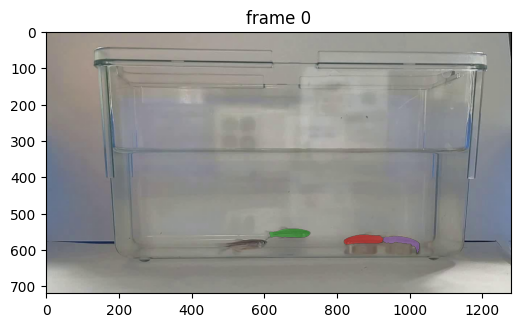

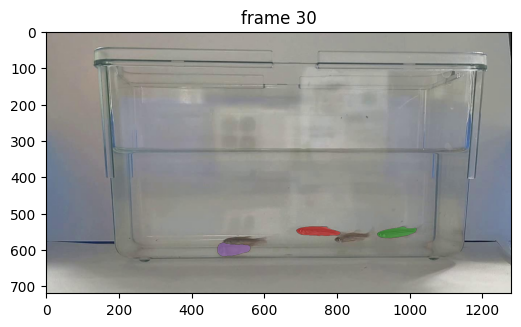

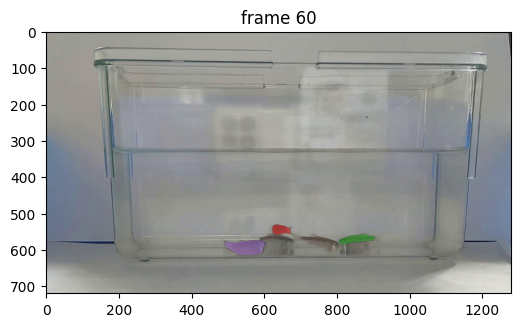

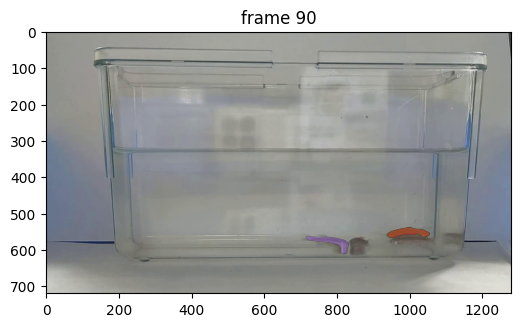

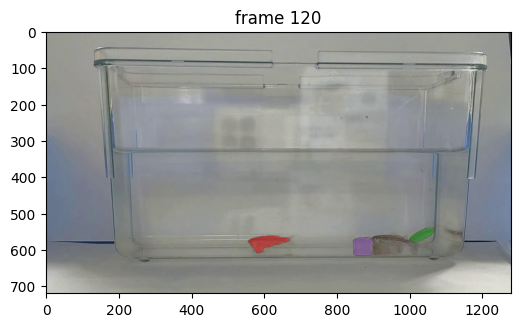

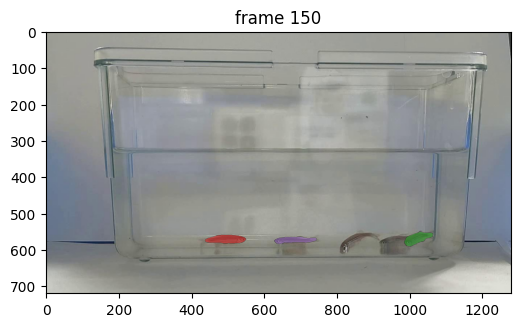

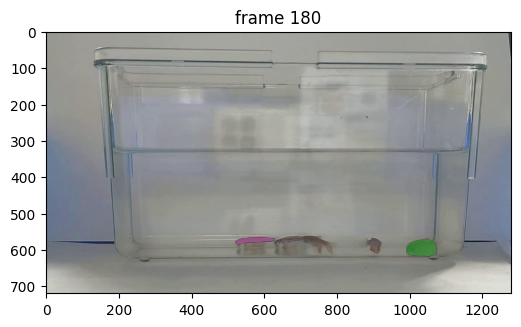

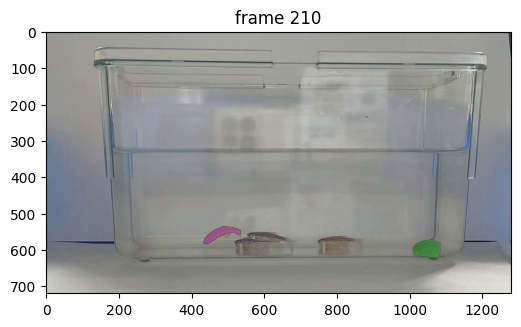

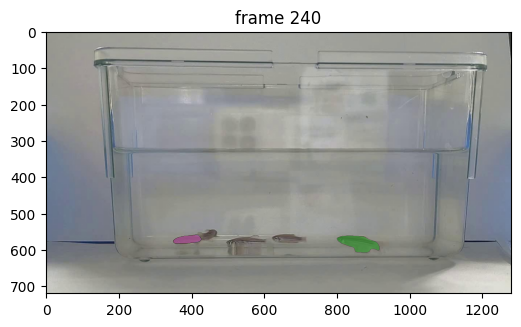

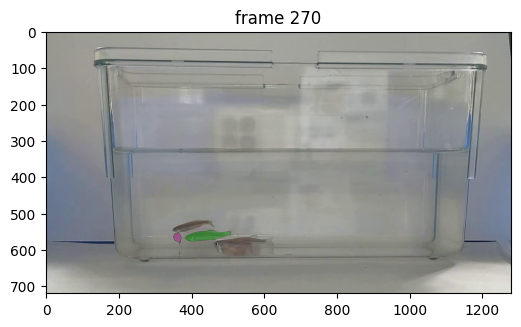

In [26]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, len(frame_names_new), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names_new[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)